In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt





In [2]:
cap = cv2.VideoCapture(0)


In [3]:
labels = ["person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
          "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
          "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack",
          "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball",
          "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket",
          "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
          "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
          "sofa", "potted plant", "bed", "dining table", "toilet", "tv monitor", "laptop", "mouse",
          "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
          "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush", "pen"]

colors = ["0,255,255", "0,0,255", "255,0,0", "255,255,0", "0,255,0"]
colors = [np.array(color.split(",")).astype("int") for color in colors]
colors = np.array(colors)
colors = np.tile(colors, (18, 1))

model = cv2.dnn.readNetFromDarknet("yolov3.cfg", "yolov3.weights")
layers = model.getLayerNames()
output_layer = [layers[layer - 1] for layer in model.getUnconnectedOutLayers().flatten()]


Detected: person: 99.54%
Detected: person: 99.71%
Detected: person: 99.72%
Detected: person: 99.68%
Detected: person: 99.70%
Detected: person: 99.66%
Detected: person: 99.72%
Detected: person: 99.72%
Detected: person: 99.71%
Detected: person: 99.72%
Detected: person: 99.73%
Detected: person: 99.71%
Detected: person: 99.63%
Detected: person: 99.53%
Detected: person: 99.57%
Detected: person: 99.61%
Detected: person: 99.62%
Detected: person: 99.63%
Detected: person: 99.62%
Detected: person: 99.53%
Detected: person: 99.58%
Detected: person: 99.59%
Detected: person: 99.57%
Detected: person: 99.55%
Detected: person: 99.52%
Detected: person: 99.58%
Detected: person: 99.56%
Detected: person: 99.60%
Detected: person: 99.56%
Detected: person: 99.55%
Detected: person: 99.62%
Detected: person: 99.58%
Detected: person: 99.57%
Detected: person: 99.56%
Detected: person: 99.55%
Detected: person: 99.63%
Detected: person: 99.63%
Detected: person: 99.56%
Detected: person: 99.59%
Detected: person: 99.61%


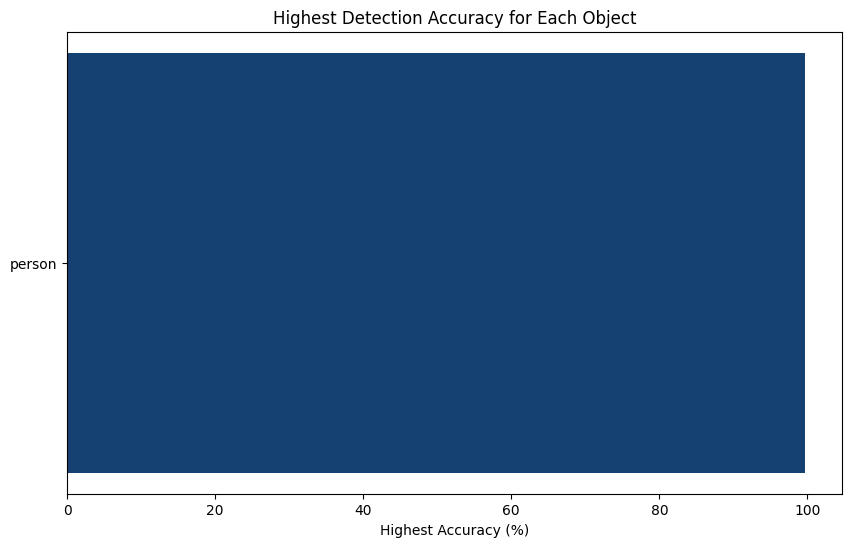

In [4]:
lines = {}  
acc_data = {}  #
detection_counts = {}  
highest_acc = {}  


try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_width = frame.shape[1]
        frame_height = frame.shape[0]
        frame_blob = cv2.dnn.blobFromImage(frame, 1/255, (160,160), swapRB=True, crop=False)

        model.setInput(frame_blob)
        detection_layers = model.forward(output_layer)

        ids_list = []
        boxes_list = []
        confidences_list = []

        for detection_layer in detection_layers:
            for object_detection in detection_layer:
                scores = object_detection[5:]
                predicted_id = np.argmax(scores)
                confidence = scores[predicted_id]

                if confidence > 0.35:
                    bounding_box = object_detection[0:4] * np.array([frame_width, frame_height, frame_width, frame_height])
                    (box_center_x, box_center_y, box_width, box_height) = bounding_box.astype("int")

                    start_x = int(box_center_x - (box_width / 2))
                    start_y = int(box_center_y - (box_height / 2))

                    ids_list.append(predicted_id)
                    confidences_list.append(float(confidence))
                    boxes_list.append([start_x, start_y, int(box_width), int(box_height)])

        # Handle NMSBoxes return value
        max_ids = cv2.dnn.NMSBoxes(boxes_list, confidences_list, 0.5, 0.4)
        if len(max_ids) > 0:
            max_ids = np.array(max_ids).flatten()
        else:
            max_ids = []

        for max_id in max_ids:
            max_class_id = max_id
            box = boxes_list[max_class_id]

            start_x = box[0]
            start_y = box[1]
            box_width = box[2]
            box_height = box[3]

            predicted_id = ids_list[max_class_id]
            label = labels[predicted_id]
            confidence = confidences_list[max_class_id]
            label_text = "{}: {:.2f}%".format(label, confidence * 100)
            box_color = colors[predicted_id]
            box_color = [int(each) for each in box_color]
            
            print(f"Detected: {label_text}")
            
            cv2.rectangle(frame, (start_x, start_y), (start_x + box_width, start_y + box_height), box_color, 2)
            cv2.putText(frame, label_text, (start_x, start_y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color, 2)
            
            # Update the highest accuracy for each label
            highest_acc[label] = max(highest_acc.get(label, 0), confidence * 100)

        cv2.imshow("Real Time Object Detection v2", frame)

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
except KeyboardInterrupt:
    pass
finally:
    cap.release()
    cv2.destroyAllWindows()

    # Plotting highest accuracies after the loop ends
    plt.figure(figsize=(10, 6))
    objects = list(highest_acc.keys())
    accuracies = [highest_acc[obj] for obj in objects]
    y_pos = np.arange(len(objects))
    
    plt.barh(y_pos, accuracies, color=np.random.rand(len(objects), 3))
    plt.yticks(y_pos, objects)
    plt.xlabel('Highest Accuracy (%)')
    plt.title('Highest Detection Accuracy for Each Object')
    plt.show()
